*Credits: this notebook origin (shared under MIT license) belongs to [ML course at ICL](https://github.com/yandexdataschool/MLatImperial2020) held by Yandex School of Data Analysis. Special thanks to the course team for making it available online.*

## week0_05: Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features # number of best features to select

    def fit(self, X, y):
        # Select features that describe the targets best, i.e. have
        # highest correlation with them: 
        covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0) #Here we have data leak
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return X[:,self.best_feature_ids]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y) #Here we have data leak by using all data, 
                                                                #and then cross-validating on its part

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9400000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

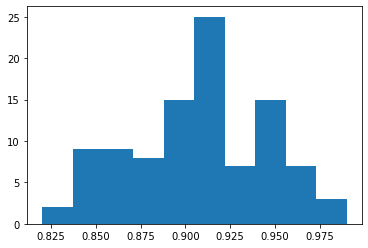

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
    # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    # Feature selection:
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)

    # Simple classification model
    model = LinearSVC()

  # Estimatin accuracy using cross-validation:
    return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Can you explain and fix this?

In [5]:
# It's dangerous to go alone. Take this!
from sklearn.pipeline import Pipeline

In [6]:
pip = Pipeline(steps = [
    ('preproc', FeatureSelector(num_features_best)),
    ('svc', LinearSVC())    ]
)

In [7]:
pip.fit(X, y)
cross_val_score(pip, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean() #With no dataleaks it looks line this

0.5199999999999999

In [8]:
print(accuracy_score(pip.predict(X), y))

1.0
